<a href="https://colab.research.google.com/github/enlupi/SNN-MUC/blob/main/Scripts/DTFastSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SNN Implementation


In [1]:
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import snntorch.functional as SF

from snntorch import spikegen

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Create Datasets

In [34]:
num_events = 100000
num_events_test = 6000

events_arr, muon_list, max_n = ge.generate_noisy_evts(num_events, noise_frac=0.4, bkg_frac=0.5)
events_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(num_events_test, noise_frac=0.4, bkg_frac=0.5)

100%|███████████████████████████████████████████| 6000/6000 [00:08<00:00, 701.59it/s]


Generate target: NLAYERSxNWIRES (4x4 by defualt) matrices with 1 if a true hit from a muon has been registered in the time

In [35]:
def gen_target(muon_list):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES), dtype=np.int16)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1

    return torch.tensor(target, dtype=torch.float32)

In [36]:
def gen_target_2(muon_list):
    target = np.zeros(shape=(len(muon_list)), dtype=np.int16)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            if hit['signal'] == True:
                target[i] = 1
                break

    return torch.tensor(target, dtype=torch.long)

In [37]:
target = gen_target_2(muon_list)
target_test = gen_target_2(muon_list_test)

100000it [00:00, 590859.39it/s]
6000it [00:00, 248058.91it/s]


### Custom Dataset and Dataloader

In [38]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        
        input_sample = self.input_data[idx]
        target_sample = self.target[idx]
        
        if self.transform:
            input_sample = self.transform(input_sample)
            
        return input_sample, target_sample


# Transformations

# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_hits, size, target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    padded_array = np.zeros(shape=(size, len(features)), dtype=target_dtype)
    for i, hit in enumerate(muon_hits):
        for j, f in enumerate(features):
            padded_array[i,j] = hit[f]  # BEWARE: implicit type conversions going on here

    return padded_array

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    tensor = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = tensor.to(target_dtype)
    
    return tensor

feature_list = ['layer', 'wire_num', 'bx', 't0']
transform = transforms.Compose([
    lambda x: convert_to(x, size=max_n, target_dtype=np.float32,
                         features=feature_list),
    lambda x: to_tensor_and_dtype(x, target_dtype=torch.float32)
])

train_dataset = CustomDataset(muon_list, target, transform=transform)
test_dataset = CustomDataset(muon_list_test, target_test, transform=transform)

### Create Spiketrain

In [39]:
def custom_spikegen(data_it, num_step=40):
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data_it.dtype)
    for n_batch, evt in enumerate(data_it):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
                
    return spike_data    

## Network Definition

In [40]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = 2#num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8

In [41]:
class Net(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
net = Net(num_inputs, num_hidden, num_outputs, num_steps).to(device)

### SNN training

In [42]:
def print_batch_accuracy(net, data, targets, batch_size, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(net, data, targets, batch_size, epoch, counter, iter_counter,
                  loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(net, data, targets, batch_size, train=True)
    print_batch_accuracy(net, test_data, test_targets, batch_size, train=False)
    print("\n")

In [43]:
batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

In [44]:
num_epochs = 5
loss_hist = []
iter_counter = 0

#loss = nn.MSELoss()
loss_fn = SF.ce_count_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


# Outer training loop
for epoch in range(num_epochs):
    batch_counter = 0
    # Minibatch training loop
    for data_it, targets_it in train_loader:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # create spike train
        spike_in = custom_spikegen(data_it, num_steps)
        spike_in = spike_in.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets_it)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
        
        batch_counter += 1
        iter_counter += 1

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.7037621140480042 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5795959234237671 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.43020498752593994 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.3502701222896576 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.363206148147583 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.3497866094112396 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.276360422372818 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.2140800505876541 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.2094574123620987 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.19488312304019928 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.19633258879184723 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.23691096901893616 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.16781215369701385 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.16682440042495728 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.2134740650653839 

Epoch: 0
B

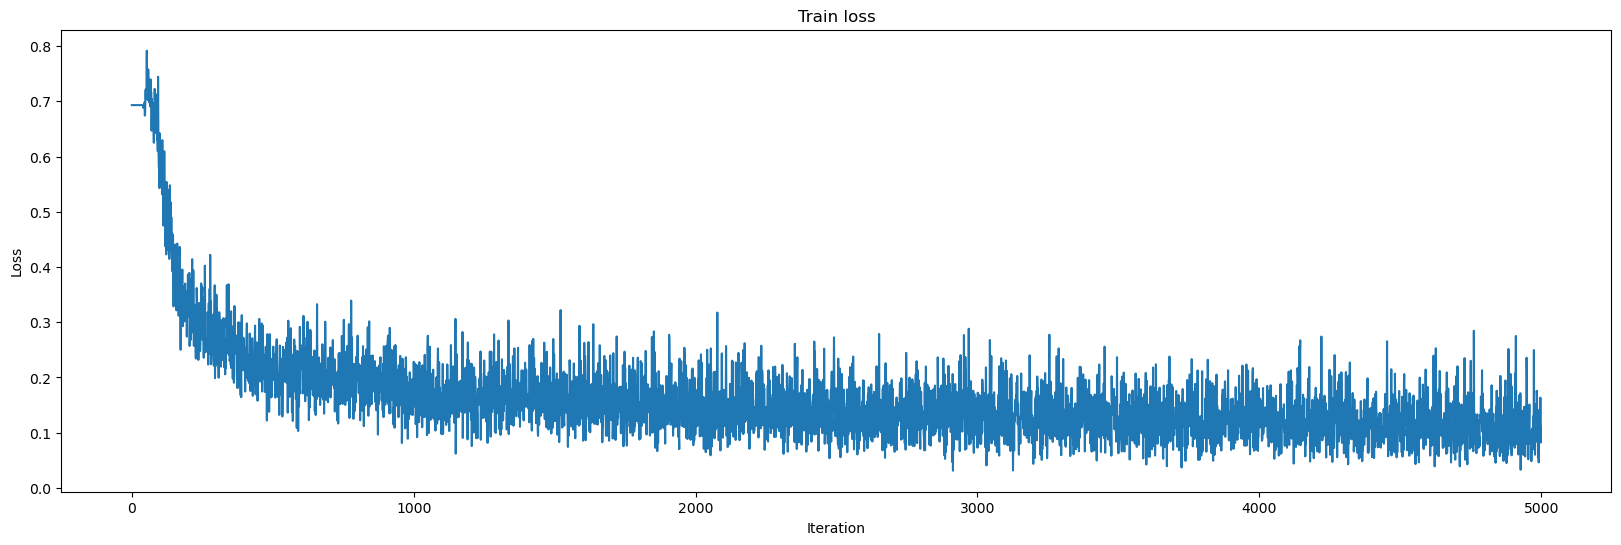

In [52]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [46]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

with torch.no_grad():
    net.eval()
    
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        #create spike train
        spike_in = custom_spikegen(data, num_steps)
        test_spike_in = spike_in.to(device)
    
        # forward pass
        test_spk, _ = net(test_spike_in.view(num_steps, batch_size, -1))

        #print(test_spk.shape)
        #print(test_spk[-1].shape)
        #print(targets.view(batch_size, -1).shape)

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        #total += targets.numel()
        #correct += (test_spk[-1] == targets.view(batch_size, -1)).sum().item()
        
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 5726/6000
Test Set Accuracy: 95.43%


## Legacy Code

In [ ]:
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

In [ ]:

train_batch = iter(train_loader)

for data_it, targets_it in train_batch:
    #print("Data_it shape:", data_it.shape)
    print("Target_it shape:", targets_it.shape)

    spike_in = custom_spikegen(data_it, num_steps)
    #print("Spike train type:", type(spike_in))
    #print("Spike train shape:", spike_in.shape)
    
    #a = data_it.view(batch_size, -1)
    #print("Data_it view shape:", a.shape)
    #b = spike_in.view(num_steps, batch_size, -1)
    #print("Data_it view shape:", b.shape)
    #print(b.dtype)

    spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))

    print("spike rec shape:", spk_rec.shape)
    #print("mem_rec shape:", mem_rec.shape)

    #print(spk_rec[-1, 0])
    #print(targets_it.view(batch_size, -1)[0])

    spike_count = torch.sum(spk_rec, 0)
    print("spike_count shape:", spike_count.shape)

    log_p_y = log_softmax_fn(spike_count)
    print("log_p_y shape:", log_p_y.shape)

    
    loss_val = torch.zeros((1), device=device)
    for i in range(batch_size):
        loss_val += loss_fn(log_p_y[i], targets_it[i])
    
    #loss_val = loss_fn(spk_rec, targets_it)

    print(loss_val)
    '''optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

        # Store loss history for future plotting
    loss_hist.append(loss_val.item())'''

    print(data_it[0])
    print(spike_in[:,0])
    
    break

In [ ]:
# Legacy transform: not needed

def pad(muon_hits, max_n_hit):
    padded_array = np.zeros(max_n_hit, dtype=ED.hit_dtype)
    for i, hit in enumerate(muon_hits):
        padded_array[i]['bx']     = hit['bx']
        padded_array[i]['tdc']    = hit['tdc']
        padded_array[i]['label']  = hit['label']
        padded_array[i]['signal'] = hit['signal']

    return padded_array

In [ ]:
def event_to_matrix(event,rec=True):
    tmp_matrix = event['tdc']*(25/30)+event['bx']*25
    tmp_matrix[tmp_matrix <0] = 0
    
    min_value = np.min(tmp_matrix)
    max_value = np.max(tmp_matrix)
    
    tmp_matrix = (tmp_matrix - min_value) / (max_value - min_value)
    
    if rec:
        tmp_matrix[tmp_matrix > 0] = 1/tmp_matrix[tmp_matrix > 0]
        
        min_value = np.min(tmp_matrix)
        max_value = np.max(tmp_matrix)

        tmp_matrix = (tmp_matrix - min_value) / (max_value - min_value)
        
    return tmp_matrix